In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np

# Deel I: Vector Space Models

In [2]:
capitals_df = pd.read_csv("data/capitals.txt", delimiter=" ", names=["city1", "country1", "city2", "country2"])
capitals_df.head()

,city1,country1,city2,country2
0,Athens,Greece,Baghdad,Iraq
1,Athens,Greece,Bangkok,Thailand
2,Athens,Greece,Beijing,China
3,Athens,Greece,Berlin,Germany
4,Athens,Greece,Bern,Switzerland


In [3]:
word_embeddings = pkl.load(open("data/word_embeddings_subset.p", "rb"))
print(list(word_embeddings.keys()))
print(type(word_embeddings))
print("size:", word_embeddings["China"].size, "\nChina embedding:\n", word_embeddings["China"][:100])

['country', 'city', 'China', 'Iraq', 'oil', 'town', 'Canada', 'London', 'England', 'Australia', 'Japan', 'Pakistan', 'Iran', 'gas', 'happy', 'Russia', 'Afghanistan', 'France', 'Germany', 'Georgia', 'Baghdad', 'village', 'Spain', 'Italy', 'Beijing', 'Jordan', 'Paris', 'Ireland', 'Turkey', 'Egypt', 'Lebanon', 'Taiwan', 'Tokyo', 'Nigeria', 'Vietnam', 'Moscow', 'Greece', 'Indonesia', 'sad', 'Syria', 'Thailand', 'Libya', 'Zimbabwe', 'Cuba', 'Ottawa', 'Tehran', 'Sudan', 'Kenya', 'Philippines', 'Sweden', 'Poland', 'Ukraine', 'Rome', 'Venezuela', 'Switzerland', 'Berlin', 'Bangladesh', 'Portugal', 'Ghana', 'Athens', 'king', 'Madrid', 'Somalia', 'Dublin', 'Qatar', 'Chile', 'Islamabad', 'Bahrain', 'Nepal', 'Norway', 'Serbia', 'Kabul', 'continent', 'Brussels', 'Belgium', 'Uganda', 'petroleum', 'Cairo', 'Denmark', 'Austria', 'Jamaica', 'Georgetown', 'Bangkok', 'Finland', 'Peru', 'Romania', 'Bulgaria', 'Hungary', 'Vienna', 'Kingston', 'Manila', 'Cyprus', 'Azerbaijan', 'Copenhagen', 'Fiji', 'Tunisia'

In [4]:
def cosine_similarity(a: np.array, b: np.array) -> np.float32:
   return np.dot(a, b) / np.dot(np.sqrt(np.sum(np.abs(a) ** 2)), np.sqrt(np.sum(np.abs(b) ** 2)))

In [5]:
def eucilidean_distance(a: np.array, b: np.array) -> np.float32:
    return np.sqrt(np.sum((a - b) ** 2))

In [6]:
cosine_similarity(word_embeddings["king"], word_embeddings["queen"])

0.65109557

In [7]:
eucilidean_distance(word_embeddings["king"], word_embeddings["queen"])

2.4796925

In [8]:
def find_closest(city1: str, country1: str, city2: str, embeddings: dict[str, np.array]) -> tuple[str, np.float32]:
    base = embeddings[country1] - embeddings[city1] + embeddings[city2] # base maar 1 keer calculeren

    max_val = -1
    max_country = None

    for key, embedding in embeddings.items(): # simpel max value algoritme
        if not key in [city1, country1, city2]:
            val = cosine_similarity(base, embedding) # similarity uitrekenen
            if val > max_val:
                max_val = val
                max_country = key

    return (max_country, max_val)

In [9]:
find_closest("Athens", "Greece", "Cairo", word_embeddings)

('Egypt', 0.7626821)

In [10]:
correct = 0

for index, (city1, country1, city2, country2) in capitals_df.iterrows(): # iterrows geeft key en value van elke row. de values unpack in gelijk naar de goede variabelen
    guess = find_closest(city1, country1, city2, word_embeddings)[0]
    if guess == country2: # als het goed is +1
        correct += 1 

print(correct/capitals_df.shape[0])

0.9192245557350566


Goed genoeg

# Deel II: Principle Component Analysis


In [11]:
def compute_PCA(X : np.array, n_components : int) -> np.array:
    # centreren op gemiddelde door gemiddelde van elke waarde af te trekken
    X_mean = X - np.mean(X, axis=0)
    
    # covariance berekenen d.m.v. numpy.cov() en tranposes want we willen de y reducen niet de x,
    # rowvar transposed de matrix zodat we de juiste vorm krijgen
    cov = np.cov(X_mean, rowvar=False)
    
    # Eigenvectors / Eigenvalues berekenen d.m.v. numpy.linalg.eigh() en de variance die we net hebben uitgerekend
    EigenValues, EigenVectors = np.linalg.eigh(cov)
    
    # sorteren eigenvalues en daar de indices van nemen met de np.ndarray.argsort() 
    # en ook gelijk omdraaien door middel van een step waarde van -1
    indices = EigenValues.argsort()[::-1]   
    
    # we nemen de indices van de gesoorterde eigenvalues en passen die toe op de eigenvectors
    # willen we de plaatsen van de rows(y-axis) aanpassen niet die van de columns (x-axis)
    EigenVectors = EigenVectors[:,indices]
    
    # nemen n values van eigenvectors
    EigenVectors = EigenVectors[:, 0:n_components]
    
    return np.matmul(X_mean, EigenVectors)

In [12]:
np.random.seed(1)
X = np.random.rand(3, 10)
X_reduced = compute_PCA(X, n_components=2)


print("De originele matrix is " + str(X.shape) + ", en na PCA:")
print(X_reduced)

De originele matrix is (3, 10), en na PCA:
[[ 0.43437323  0.49820384]
 [ 0.42077249 -0.50351448]
 [-0.85514571  0.00531064]]


In [13]:
def get_embeddings(words: list[str], embeddings: dict[str, np.array]):
    return [value for key, value in embeddings.items() if key in words]

In [14]:
labels = ['oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']
label_embeddings = get_embeddings(labels, word_embeddings)
print("Embedding oil:", end=None)
label_embeddings[0][:100]

Embedding oil:


array([-0.08007812,  0.13378906,  0.14355469,  0.09472656, -0.04736328,
       -0.02355957, -0.00854492, -0.18652344,  0.04589844, -0.08154297,
       -0.03442383, -0.11621094,  0.21777344, -0.10351562, -0.06689453,
        0.15332031, -0.19335938,  0.26367188, -0.13671875, -0.05566406,
        0.07470703, -0.00070953,  0.09375   , -0.14453125,  0.04296875,
       -0.01916504, -0.22558594, -0.12695312, -0.0168457 ,  0.05224609,
        0.0625    , -0.1484375 , -0.01965332,  0.17578125,  0.10644531,
       -0.04760742, -0.10253906, -0.28515625,  0.10351562,  0.20800781,
       -0.07617188, -0.04345703,  0.08642578,  0.08740234,  0.11767578,
        0.20996094, -0.07275391,  0.1640625 , -0.01135254,  0.0025177 ,
        0.05810547, -0.03222656,  0.06884766,  0.046875  ,  0.10107422,
        0.02148438, -0.16210938,  0.07128906, -0.16210938,  0.05981445,
        0.05102539, -0.05566406,  0.06787109, -0.03759766,  0.04345703,
       -0.03173828, -0.03417969, -0.01116943,  0.06201172, -0.08

In [15]:
computed_embeddings = compute_PCA(label_embeddings, 2)

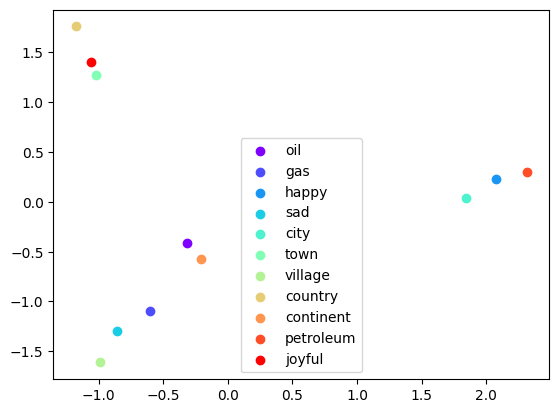

In [16]:
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(labels)))

for index, values in enumerate(computed_embeddings):
    plt.scatter(*values, color=colors[index], label=labels[index])
    
plt.legend()

woorden die een beetje bij elkaar horen I.e. city, town en village liggen bij elkaar. Ze hebben een bepaalde relatie en die relatie is hier duidelijk te zien. Ook sad, happy, en joyful hebben een "sterke" relatie